# Analyse Fragments

Hypothesis: 
1. Fragments can be described by angles. 
2. Given a set of PDBs we can represent distributions of angles using a gaussian.
3. Given a new PDB and angles we can calculate the probability that a segment is sampled from the same distribution.
 

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_npy_arrays(folder_path):
    fragment_arrays = {}
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".npy"):
                fragment_number = os.path.basename(root)  # Assuming the folder name represents the fragment number
                fragment_arrays[fragment_number] = np.load(os.path.join(root, file))
    return fragment_arrays

def plot_angles_distribution(angles):
    """
    Plots the angles distribution for each amino acid position across all samples within a fragment.
    
    Parameters:
    - angles: numpy.ndarray, the angles array with shape (n_samples, n_amino_acids, 4).
    """
    n_samples, n_amino_acids, _ = angles.shape
    angle_names = ['Omega', 'Phi', 'Psi', 'CA']
    
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15), sharex=True)
    
    for i, angle_name in enumerate(angle_names):
        ax = axes[i]
        for position in range(n_amino_acids):
            angle_data = angles[:, position, i]  # Get all samples for this position and angle
            ax.scatter(angle_data, [position] * n_samples, alpha=0.5, label=f'Position {position+1}' if i == 0 else "")
        
        ax.set_ylabel('Amino Acid Position')
        ax.set_title(angle_name)
        ax.set_ylim(-1, n_amino_acids)
        ax.grid(True)
    
    axes[-1].set_xlabel('Angle (degrees)')
    plt.tight_layout()
    plt.show()
    
def plot_psi_vs_phi(fragments_dict, fragment_number):
    """
    Creates a scatter plot of psi vs phi angles for each amino acid position within a selected fragment,
    labeling each position.
    
    Parameters:
    - fragments_dict: dict, a dictionary where keys are fragment numbers and values are the angles arrays.
    - fragment_number: int, the selected fragment number to plot.
    """
    angles = fragments_dict.get(fragment_number)
    if angles is None:
        print(f"No data found for fragment {fragment_number}.")
        return
    
    # Extracting phi (index 1) and psi (index 2) angles for all positions
    phi_angles = angles[:, :, 1].flatten()
    psi_angles = angles[:, :, 2].flatten()
    positions = np.tile(np.arange(1, angles.shape[1] + 1), angles.shape[0])
    
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(phi_angles, psi_angles, c='blue', alpha=0.5)
    
    # Labeling each point with its amino acid position
    for i, txt in enumerate(positions):
        plt.annotate(txt, (phi_angles[i], psi_angles[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, alpha=0.3)
    
    plt.title(f'Psi vs Phi Angles for Fragment {fragment_number}', fontsize=14)
    plt.xlabel('Phi (\u03C6) Angles (degrees)', fontsize=12)
    plt.ylabel('Psi (\u03C8) Angles (degrees)', fontsize=12)
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

import nglview as nv
from pathlib import Path

def display_pdb_structure(fragment_number, folder_path):
    """
    Displays the first PDB structure found in the specified fragment's directory.
    
    Parameters:
    - fragment_number: int, the selected fragment number to visualize.
    - folder_path: str, base path to the directory containing fragment subdirectories.
    """
    fragment_folder = Path(folder_path) / f'{fragment_number}'
    pdb_file = next(fragment_folder.glob('*.pdb1'), None)

    if pdb_file:
        # Displaying the protein structure
        view = nv.show_file(str(pdb_file))
        view.camera = 'orthographic'
        display(view)
    else:
        print(f"No PDB file found for fragment {fragment_number}.")

import numpy as np
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def create_sparse_representation(fragments_dict):
    """
    Creates a sparse grid representation for each fragment's psi and phi angles.
    Returns a dictionary where keys are fragment numbers and values are sparse matrices.
    """
    grid_size = 360  # Using a 360x360 grid
    fragment_grids = {}
    
    for fragment_number, angles in fragments_dict.items():
        # Convert angles to grid coordinates (0 to 359)
        phi_indices = (angles[:, :, 1].flatten() + 180).astype(int)
        psi_indices = (angles[:, :, 2].flatten() + 180).astype(int)
        
        # Create a sparse matrix for the grid
        grid_indices = np.ravel_multi_index((phi_indices, psi_indices), (grid_size, grid_size))
        grid_counts = np.bincount(grid_indices, minlength=grid_size*grid_size)
        sparse_grid = csr_matrix(grid_counts.reshape(grid_size, grid_size))
        
        fragment_grids[fragment_number] = sparse_grid
    
    return fragment_grids

def compute_cosine_distances(fragment_grids):
    """
    Computes the cosine distances between all pairs of fragment grids.
    Returns a condensed distance matrix suitable for hierarchical clustering.
    """
    fragment_numbers = list(fragment_grids.keys())
    n = len(fragment_numbers)
    distances = np.zeros((n * (n - 1)) // 2)
    
    k = 0
    for i in range(n):
        for j in range(i+1, n):
            grid_i = fragment_grids[fragment_numbers[i]].toarray().flatten()
            grid_j = fragment_grids[fragment_numbers[j]].toarray().flatten()
            distances[k] = cosine(grid_i, grid_j)
            k += 1
            
    return distances

def perform_hierarchical_clustering(distances, fragment_numbers):
    """
    Performs hierarchical clustering on the cosine distances and plots a dendrogram.
    """
    Z = linkage(distances, 'ward')  # Using average linkage
    plt.figure(figsize=(15, 7))
    dendrogram(Z, labels=fragment_numbers, orientation='right')
    plt.title('Hierarchical Clustering of Fragments')
    plt.xlabel('Distance')
    plt.ylabel('Fragment Number')
    plt.show()


def display_separate_pdb_structures(fragment_numbers, folder_path):
    """
    Displays PDB structures for the specified fragment numbers in separate viewer instances.
    
    Parameters:
    - fragment_numbers: list of int, the selected fragment numbers to visualize.
    - folder_path: str, base path to the directory containing fragment subdirectories.
    """
    for fragment_number in fragment_numbers:
        fragment_folder = Path(folder_path) / f'{fragment_number}'
        pdb_file = next(fragment_folder.glob('*.pdb1'), None)
        
        if pdb_file:
            view = nv.show_file(str(pdb_file))
            view.camera = 'orthographic'
            display(view)
        else:
            print(f"No PDB file found for fragment {fragment_number}.")

In [118]:
fragment_arrays['2'][:,:,:3].shape

(15, 20, 3)

In [3]:
folder_path = '../data/fragments/'
fragment_arrays = load_npy_arrays(folder_path)

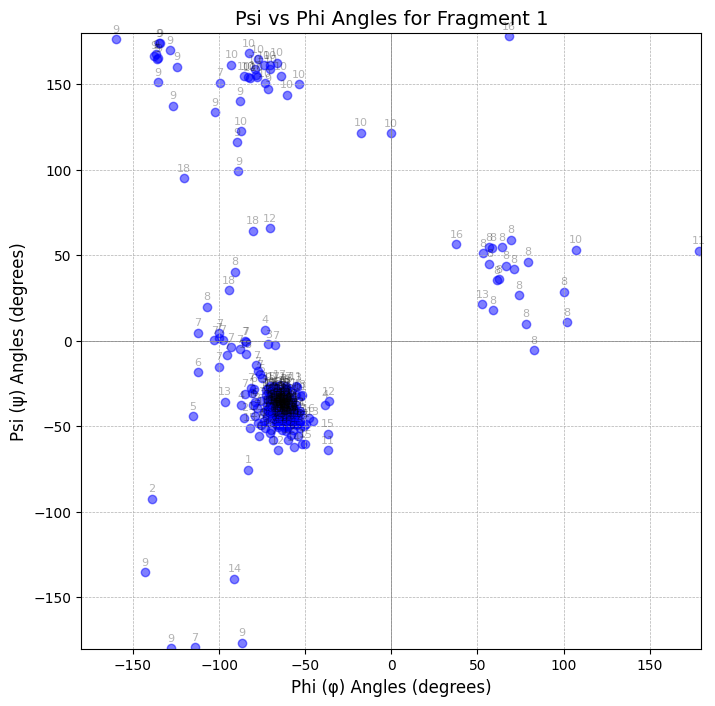

NGLWidget()

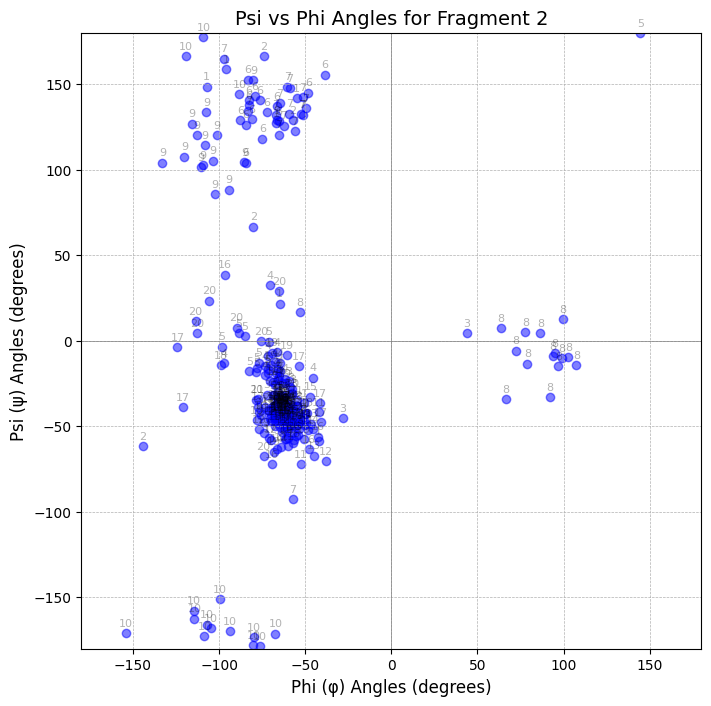

NGLWidget()

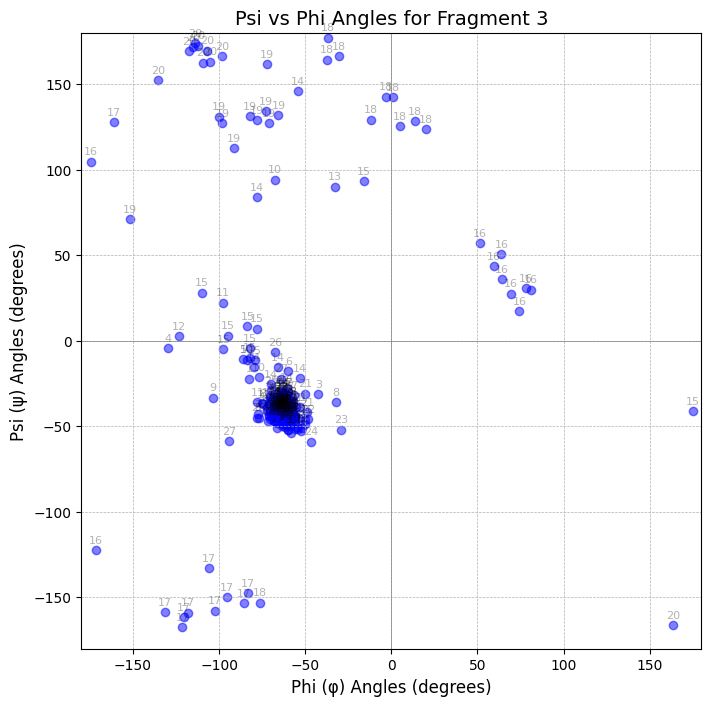

NGLWidget()

In [4]:
for i in range(1, 4):
    plot_psi_vs_phi(fragment_arrays, str(i))
    display_pdb_structure(str(i), folder_path)

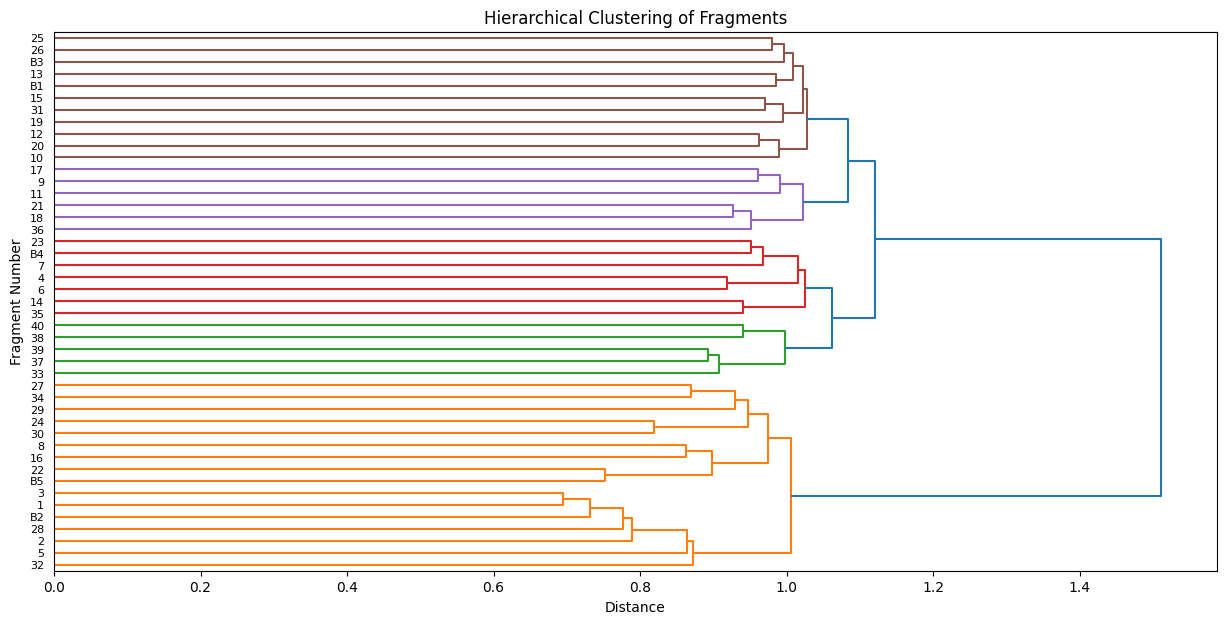

In [5]:
fragment_grids = create_sparse_representation(fragment_arrays)
distances = compute_cosine_distances(fragment_grids)
perform_hierarchical_clustering(distances, list(fragment_arrays.keys()))


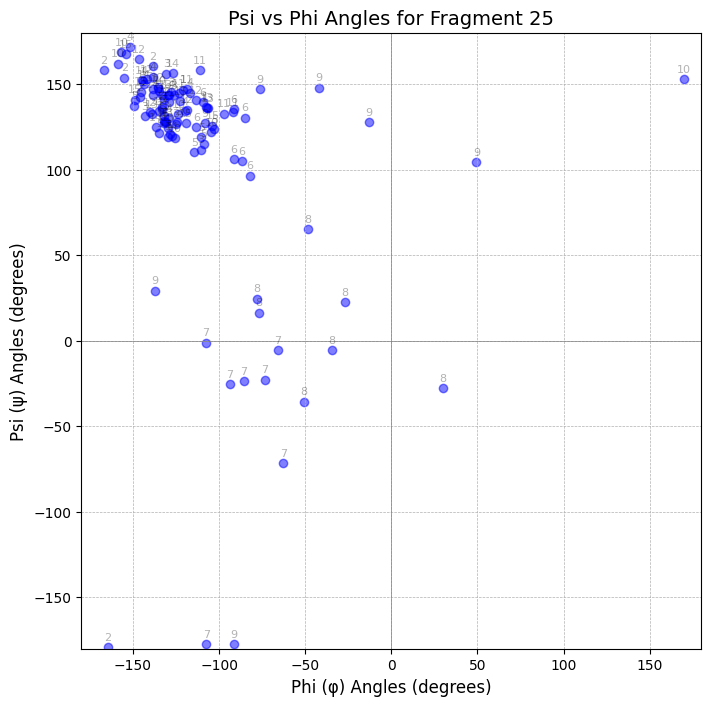

NGLWidget()

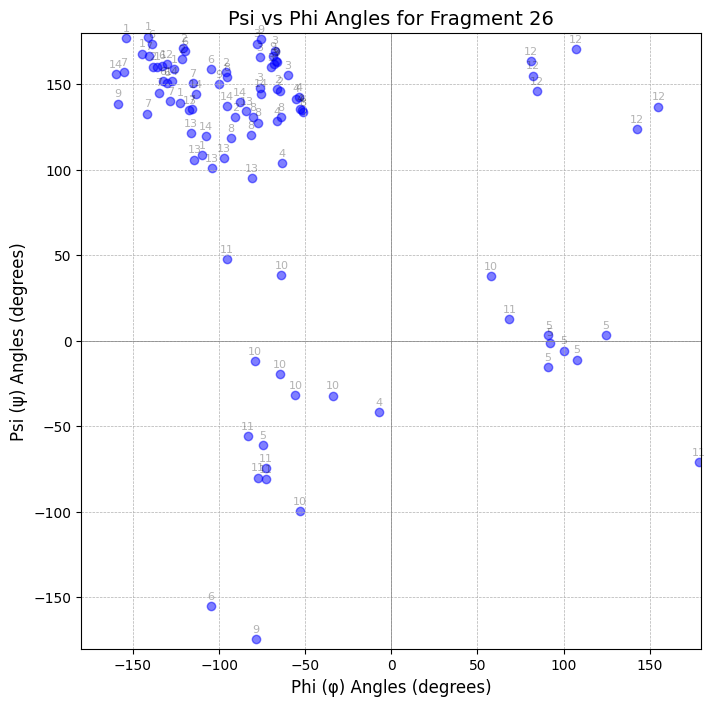

NGLWidget()

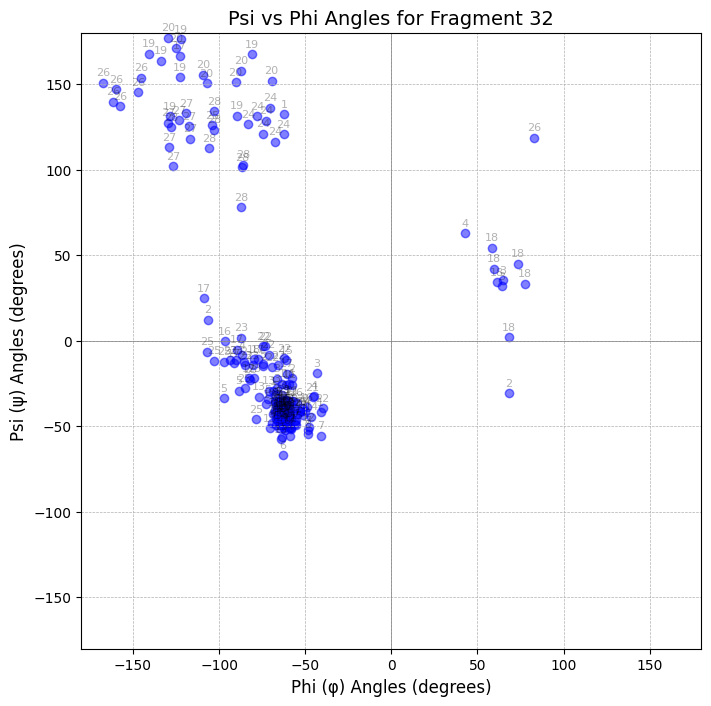

NGLWidget()

In [7]:
for i in [25, 26, 32]:
    plot_psi_vs_phi(fragment_arrays, str(i))
    display_pdb_structure(str(i), folder_path)

# Classifying fragments

In [33]:
from pathlib import Path
import numpy as np
from Bio.PDB import PDBParser, Superimposer
from concurrent.futures import ProcessPoolExecutor

def get_first_pdb_path(directory):
    return next(directory.glob('*.pdb1'), None)

def calculate_rmsd(pdb_file_1, pdb_file_2):
    parser = PDBParser()
    structure_1 = parser.get_structure('structure_1', pdb_file_1)
    structure_2 = parser.get_structure('structure_2', pdb_file_2)

    atoms_1 = [atom for atom in structure_1.get_atoms() if atom.get_name() == 'CA'][:7]
    atoms_2 = [atom for atom in structure_2.get_atoms() if atom.get_name() == 'CA'][:7]

    if len(atoms_1) != len(atoms_2):
        return np.nan  # Cannot calculate RMSD if atom counts differ

    sup = Superimposer()
    sup.set_atoms(atoms_1, atoms_2)
    return sup.rms

def rmsd_worker(args):
    pdb_file_1, pdb_file_2 = args
    return calculate_rmsd(pdb_file_1, pdb_file_2)

def create_distance_matrix(folder_path):
    folder_path = Path(folder_path)
    fragment_dirs = [d for d in folder_path.iterdir() if d.is_dir()]
    pdb_paths = [get_first_pdb_path(d) for d in fragment_dirs]
    
    pdb_paths = list(filter(None, pdb_paths))  # Ensure no None paths
    
    n = len(pdb_paths)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            rmsd_value = calculate_rmsd(str(pdb_paths[i]), str(pdb_paths[j]))
            distance_matrix[i, j] = rmsd_value
            distance_matrix[j, i] = rmsd_value  # Symmetric matrix

    return distance_matrix


# Example usage
folder_path = '../data/fragments/'
distance_matrix = create_distance_matrix(folder_path)
print(distance_matrix)

[[0.         1.2638272  3.68412816 ... 2.45576915 1.10450909 3.72861506]
 [1.2638272  0.         4.1758633  ... 3.11648755 0.37304876 4.26964152]
 [3.68412816 4.1758633  0.         ... 4.31665787 4.21371088 0.67537965]
 ...
 [2.45576915 3.11648755 4.31665787 ... 0.         3.06113319 4.21219452]
 [1.10450909 0.37304876 4.21371088 ... 3.06113319 0.         4.3105726 ]
 [3.72861506 4.26964152 0.67537965 ... 4.21219452 4.3105726  0.        ]]


In [34]:
distance_matrix.shape

(45, 45)

In [36]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.1 MB/s eta 0:00:00a 0:00:01


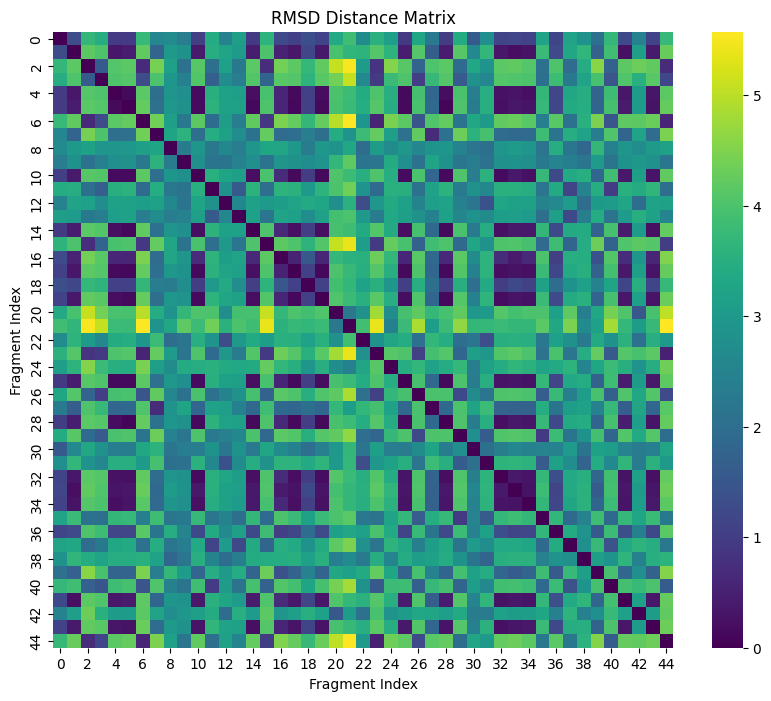

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming distance_matrix is the matrix returned by create_distance_matrix function


# Displaying the matrix using seaborn's heatmap function for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, fmt=".2f", cmap='viridis')
plt.title("RMSD Distance Matrix")
plt.xlabel("Fragment Index")
plt.ylabel("Fragment Index")
plt.show()


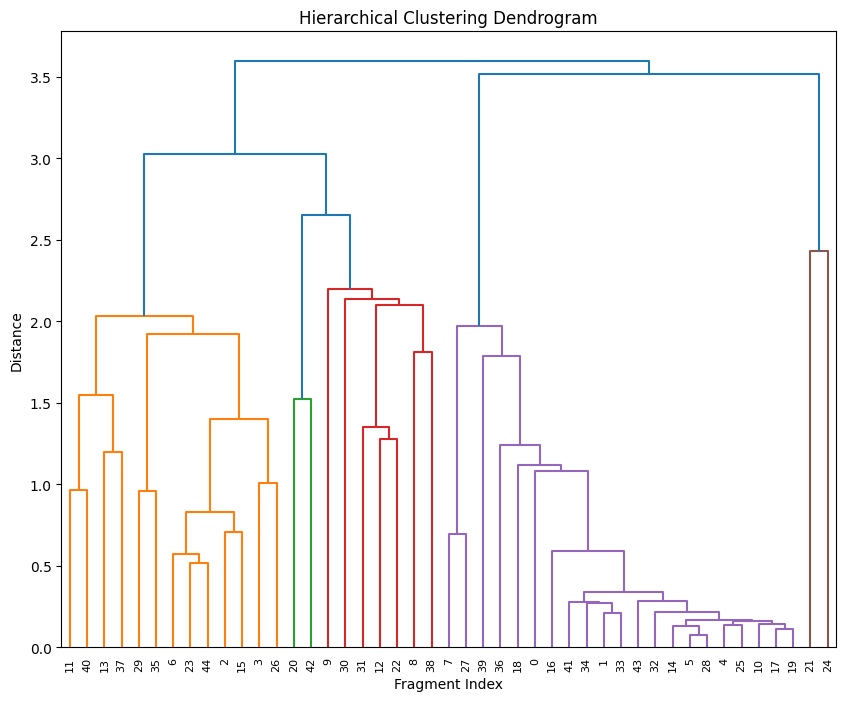

In [40]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# Assuming distance_matrix is obtained from create_distance_matrix function
# Convert the upper triangular part of the distance matrix to a condensed form
condensed_dist_matrix = squareform(distance_matrix, checks=False)

# Perform hierarchical clustering
Z = linkage(condensed_dist_matrix, 'average')  # 'average' linkage method

# Plot the dendrogram
plt.figure(figsize=(10, 8))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Fragment Index")
plt.ylabel("Distance")
plt.show()

In [41]:
!pip install pydssp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 6.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 7.1 MB/s eta 0:00:0000:0100:01


In [44]:
import ampal

In [66]:
fragment_length = []
for k in fragment_arrays.keys():
    fragment_length.append(fragment_arrays[k].shape[1])
fragment_length.sort()
print(set(fragment_length))

{7, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 45}


In [60]:
def print_dssp_for_pdb(pdb_file_path):
    with open(pdb_file_path, 'r') as f:
        pdb_text = f.read()
        coord = pydssp.read_pdbtext(pdb_text)
        dsspline = ''.join(pydssp.assign(coord))
        print(f"DSSP for {Path(pdb_file_path).name}: {dsspline}")

def process_fragments(folder_path):
    fragment_folders = sorted(Path(folder_path).iterdir(), key=lambda x: x.name)
    for fragment_folder in fragment_folders:
        if fragment_folder.is_dir():
            print(f"Fragment: {fragment_folder.name}")
            for pdb_file in sorted(fragment_folder.glob("*.pdb*"), key=lambda x: x.name):
                print_dssp_for_pdb(pdb_file)

In [61]:
process_fragments("../data/fragments/")

Fragment: 1
DSSP for 1A9X.pdb1: -HHHHHH----HHHHHHHH-
DSSP for 1AIS.pdb1: -HHHHHHH---HHHHHHHH-
DSSP for 1F44.pdb1: -HHHHHHH----HHHHHHH--
DSSP for 1GKU.pdb1: -HHHHH-----HHHHHHHH-
DSSP for 1HLV.pdb1: -HHHHHHH---HHHHHHHH-
DSSP for 1I3J.pdb1: -HHHHHHH---HHHHHHHH-
DSSP for 1J5Y.pdb1: -HHHHHHH---HHHHHHHH-
DSSP for 1JHG.pdb1: -HHHHHHH---HHHHHHHH-
DSSP for 1KU3.pdb1: -HHHHHHH---HHHHHHHH-
DSSP for 1LDJ.pdb1: ---HHHH----HHHHHHHH-
DSSP for 1NR3.pdb1: ----HHHHHH----------
DSSP for 1P4W.pdb1: -HHHHHHH---HHHHHHHH-
DSSP for 1R8E.pdb1: -HHHHHHH---HHHHHHHH-
DSSP for 1VZ0.pdb1: -HHHHHHH---HHHHHHHH-
DSSP for 2AVU.pdb1: -HHHHHH----HHHHHHHH-
DSSP for 2CSB.pdb1: -HHHHHHH---HHHHH----
DSSP for 2R1J.pdb1: -HHHHHHH---HHHHHHHH-
DSSP for 2V4J.pdb1: -HHHHHHH---HHHHHHH--
DSSP for 3L00.pdb1: -HHHHHH------HHHHHHHH-
DSSP for 4CDP.pdb1: -HHHHHH----HHHHHHHH-
Fragment: 10
DSSP for 1DM9.pdb1: -EE--EE------------EE-
DSSP for 1FM0.pdb1: -EE--EE------------EE-
DSSP for 1P9K.pdb1: -EE--E--------------EE-
DSSP for 1RYJ.pdb1: -E

In [113]:
from scipy.spatial.distance import cosine
import numpy as np

def calculate_cosine_distance(segment_angles, fragment_angles):
    # Ensure the arrays are of equal length by slicing the fragment angles
    min_length = min(len(segment_angles), len(fragment_angles))
    segment_vector = np.array(segment_angles[:min_length]).flatten()
    fragment_vector = np.array(fragment_angles[:min_length]).flatten()
    # Calculate and return the cosine distance
    return cosine(segment_vector, fragment_vector)

def calculate_angles_for_structure(residues):
    angles = []
    for i, residue in enumerate(residues[1:-1], start=1):  # Skip first and last
        if (
            i - 1 < len(residues) - 2
        ):  # Ensure we don't go out of bounds after removing residues
            r_prev = residues[i - 1]
            r_curr = residue
            r_next = residues[i + 1]

            omega = ampal.geometry.dihedral(
                r_prev["CA"], r_prev["C"], r_curr["N"], r_curr["CA"]
            )
            phi = ampal.geometry.dihedral(
                r_prev["C"], r_curr["N"], r_curr["CA"], r_curr["C"]
            )
            psi = ampal.geometry.dihedral(
                r_curr["N"], r_curr["CA"], r_curr["C"], r_next["N"]
            )
            ca = ampal.geometry.angle_between_vectors(r_prev["CA"], r_curr["CA"])
            print(ca)
            angles.append([omega, phi, psi, ca])
    return angles
    
def classify_protein(residues, fragment_arrays, threshold=0.8):
    # Sort fragment arrays by the size of fragments (n_amino_acids)
    sorted_fragments = sorted(fragment_arrays.items(), key=lambda x: x[1].shape[1])
    
    protein_classification = np.zeros(len(residues), dtype=int)
    window_start = 0
    
    while window_start < len(residues):
        for fragment_number, fragment_array in sorted_fragments:
            window_size = fragment_array.shape[1]
            if window_start + window_size > len(residues):
                continue  # Skip if the window goes beyond the protein length
                
            segment = residues[window_start:window_start+window_size]
            segment_angles = calculate_angles_for_structure(segment)
            
            # Calculate distances to each sample in the fragment
            distances = [calculate_cosine_distance(segment_angles, fragment_array[i]) for i in range(fragment_array.shape[0])]
            avg_distance = np.mean(distances)
            if fragment_number == 1:
                print(avg_distance)
            # Assuming a threshold to determine a match (this threshold needs to be defined based on your data)
            if avg_distance < threshold:
                protein_classification[window_start:window_start+window_size] = fragment_number
                window_start += window_size
                break
        else:
            # No fragment matched; consider the current position as disordered and move forward
            protein_classification[window_start] = -1  # -1 to indicate disordered or not part of any fragment
            window_start += 1
    
    return protein_classification

def is_numeric(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

# Assuming fragment_arrays is your original dictionary
filtered_fragment_arrays = {k: v for k, v in fragment_arrays.items() if is_numeric(k)}
structure = ampal.load_pdb("../data/fragments/17/1C52.pdb1")
structure = structure
classify_protein(list(structure.get_monomers()), filtered_fragment_arrays)

4.287037223241027
2.720889957071739
4.29102131388257
0.6846957874972518
4.866426919007813


array([17, 17, 17, 17, 17, 17, 17, -1, -1])

In [92]:
from Bio.PDB import PDBParser, PDBIO
from Bio.PDB.Polypeptide import PPBuilder
import os
import numpy as np

def calculate_rmsd(pdb_file_1, pdb_file_2):
    parser = PDBParser()
    structure_1 = parser.get_structure('structure_1', pdb_file_1)
    structure_2 = parser.get_structure('structure_2', pdb_file_2)

    atoms_1 = [atom for atom in structure_1.get_atoms() if atom.get_name() == 'CA'][:7]
    atoms_2 = [atom for atom in structure_2.get_atoms() if atom.get_name() == 'CA'][:7]

    if len(atoms_1) != len(atoms_2):
        return np.nan  # Cannot calculate RMSD if atom counts differ

    sup = Superimposer()
    sup.set_atoms(atoms_1, atoms_2)
    return sup.rms

def save_to_temp_pdb(structure, start, end, temp_pdb_filename):
    # Extracts the specified segment and saves it to a temporary PDB file
    ppb = PPBuilder()
    for pp in ppb.build_peptides(structure):
        segment = pp[start:end]
        io = PDBIO()
        io.set_structure(segment)
        io.save(temp_pdb_filename)

def classify_protein(protein_pdb_file, fragments_dir, window_size=7):
    parser = PDBParser()
    structure = parser.get_structure("protein", protein_pdb_file)
    
    protein_classification = []
    
    for i in range(len(structure.get_residues()) - window_size + 1):
        temp_pdb_filename = f"temp_segment_{i}.pdb"
        
        # Save the current segment to a temporary PDB file
        save_to_temp_pdb(structure, i, i + window_size, temp_pdb_filename)
        
        fragment_files = [f for f in os.listdir(fragments_dir) if f.endswith('.pdb')]
        matches = []
        for fragment_file in fragment_files:
            fragment_pdb_file = os.path.join(fragments_dir, fragment_file)
            rmsd = calculate_rmsd(temp_pdb_filename, fragment_pdb_file)
            
            if rmsd < 1.5:
                matches.append((fragment_file, rmsd))
        
        # Clean up the temporary PDB file
        os.remove(temp_pdb_filename)
        
        if matches:
            # Here, you can decide how to handle multiple matches, e.g., select the one with the lowest RMSD
            best_match = min(matches, key=lambda x: x[1])
            protein_classification.append((i, best_match))
        else:
            protein_classification.append((i, None))
    
    return protein_classification

# Example usage
protein_pdb_file = "../data/fragments/1/1A9X.pdb1"
fragments_dir = "../data/fragments/"
classification = classify_protein(protein_pdb_file, fragments_dir)
print(classification)

TypeError: object of type 'generator' has no len()

In [119]:
>>> import numpy as np
>>> from tmtools import tm_align
>>>
>>> coords1 = np.array(
...     [[1.2, 3.4, 1.5],
...      [4.0, 2.8, 3.7],
...      [1.2, 4.2, 4.3],
...      [0.0, 1.0, 2.0]])
>>> coords2 = np.array(
...     [[2.3, 7.4, 1.5],
...      [4.0, 2.9, -1.7],
...      [1.2, 4.2, 4.3]])
>>>
>>> seq1 = "AYLP"
>>> seq2 = "ARN"
>>>
>>> res = tm_align(coords1, coords2, seq1, seq2)
>>> res.t
array([ 2.94676159,  5.55265245, -1.75151383])
>>> res.u
array([[ 0.40393231,  0.04161396, -0.91384187],
       [-0.59535733,  0.77040999, -0.22807475],
       [ 0.69454181,  0.63618922,  0.33596866]])
>>> res.tm_norm_chain1
0.3105833326322145
>>> res.tm_norm_chain2
0.414111110176286

ModuleNotFoundError: No module named 'tmtools'

In [135]:
from tmtools import tm_align
>>> coords1 = np.array(
...     [[1.2, 3.4, 1.5],
...      [4.0, 2.8, 3.7],
...      [1.2, 4.2, 4.3],
...      [0.0, 1.0, 2.0]])
>>> coords2 = np.array(
...     [[2.3, 7.4, 1.5],
...      [4.0, 2.9, -1.7],
...      [1.2, 4.2, 4.3]])

>>> res = tm_align(coords1, coords1, "G"*len(coords1),  "G"*len(coords1))
res.tm_norm_chain1

1.0

In [130]:
res.u

array([[ 0.40393231,  0.04161396, -0.91384187],
       [-0.59535733,  0.77040999, -0.22807475],
       [ 0.69454181,  0.63618922,  0.33596866]])

In [ ]:
import ampal
import numpy as np
import os

def calculate_rmsd(segment, fragment):
    # This function calculates RMSD between the segment and fragment using AMPAL.
    # Note: This assumes both segment and fragment are AMPAL Assembly objects.
    return segment.rmsd(fragment)

def classify_protein_with_ampal(protein_pdb_file, fragments_dir, window_size=15, step_size=5, rmsd_threshold=2.5):
    # Load the protein structure from a PDB file using AMPAL
    protein_structure = ampal.load_pdb(protein_pdb_file)
    
    # Assuming the protein structure is correctly loaded and is a single chain
    if isinstance(protein_structure, ampal.AmpalContainer):
        protein_structure = protein_structure[0]  # Select the first chain if there are multiple
    
    protein_classification = []
    
    i = 0
    while i < len(protein_structure) - window_size + 1:
        segment= protein_structure.get_slice_from_res_id(i, i+window_size).backbone
        segment_pdb_str = segment.make_pdb()
        segment_ampal = ampal.load_pdb_string(segment_pdb_str, path=False)
        
        matches = []
        for fragment_file in os.listdir(fragments_dir):
            if fragment_file.endswith('.pdb'):
                fragment_pdb_file = os.path.join(fragments_dir, fragment_file)
                fragment = ampal.load_pdb(fragment_pdb_file)
                
                rmsd = calculate_rmsd(segment_ampal, fragment)
                matches.append((fragment_file, rmsd))
        if matches:
            best_match = min(matches, key=lambda x: x[1])
            if best_match[1] <= rmsd_threshold:
                # If the best match is within the RMSD threshold, classify this segment and move the window 
                protein_classification.append((i, best_match))
                i += window_size
            else:
                # Otherwise, classify this segment as the closest fragment and move the window by 1 step_size
                protein_classification.append((i, best_match))
        else:
            protein_classification.append((i, None))
        
        i += step_size  # Ensure we always move the window if no matches are found
    
    return protein_classification

# Example usage
protein_pdb_file = "path/to/your/protein.pdb"
fragments_dir = "../data/fragments/"
classification = classify_protein_with_ampal(protein_pdb_file, fragments_dir)
print(classification)
